## Numba: compiled Python

We know that Python is slow—that's why we use Python and C++. However, "rewrite in C++" is a roadblock in development from simple Python tests to a full-dataset algorithm.

It's not always necessary to rewrite in C++. There are compilers for Python.

Demonstration: start with a pure Python algorithm. The code below draws a fractal.

In [1]:
%matplotlib inline
import numpy, numba, matplotlib.pyplot, time

In [2]:
def run_python(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

In [5]:
starttime = time.time()
fractal = run_python(800, 1200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (800 * 1200)))

6164.652357498805 ns per pixel


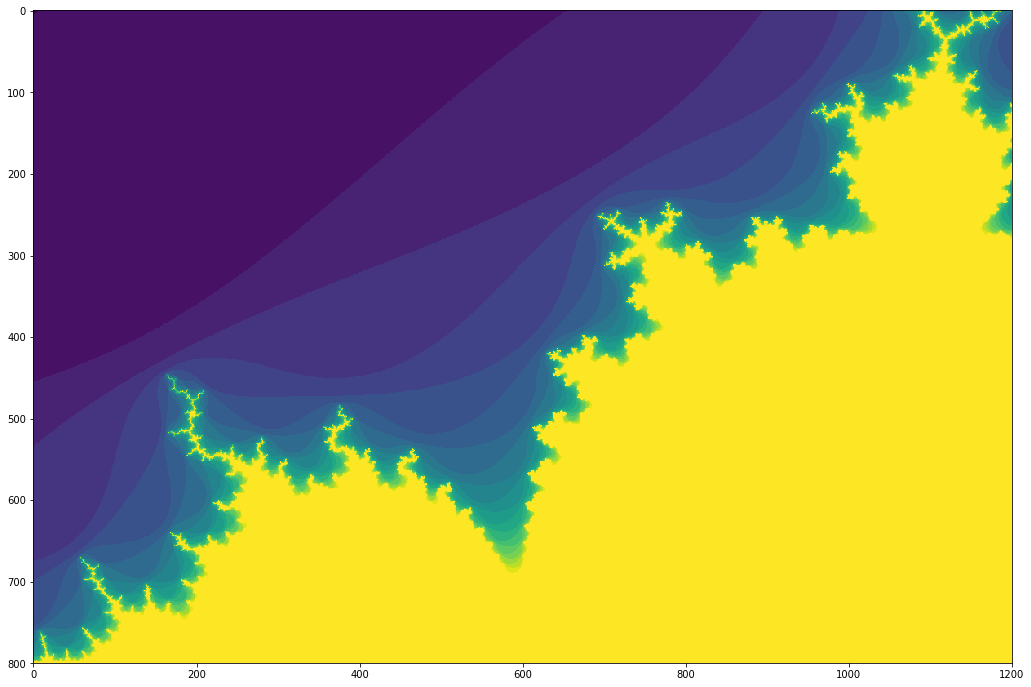

In [6]:
fig, ax = matplotlib.pyplot.subplots(figsize=(18, 12))
ax.imshow(fractal)

Since Numpy operates array-at-a-time, you have to completely rethink the problem to use Numpy (same for Awkward).

In [7]:
def run_numpy(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

In [10]:
starttime = time.time()
fractal = run_numpy(1600, 2400)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

352.15113312005997 ns per pixel


Numpy is 17× faster than pure Python _even though_ it can't `break` when done with a given pixel.

With Numba, we can make the pure Python code fast by inserting `@numba.jit` before the function.

In [11]:
@numba.jit
def run_numba(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

In [14]:
starttime = time.time()
fractal = run_numba(3200, 4800)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

116.18270849188168 ns per pixel


Numba is 50× faster than pure Python without changing the code.

Converting it all to C++ is not an automatic win.

In [15]:
import ROOT
tmpname = "run_cpp1"
ROOT.gInterpreter.Declare("""
#include<complex>
void %s(int height, int width, int maxiterations, size_t c_ptr, size_t fractal_ptr) {
    double* c = (double*)(c_ptr);
    int* fractal = (int*)(fractal_ptr);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            double creal = c[2 * (h + height*w)];
            double cimag = c[2 * (h + height*w) + 1];
            std::complex<double> ci = std::complex<double>(creal, cimag);
            std::complex<double> z = ci;
            for (int i = 0;  i < maxiterations;  i++) {
                z = z*z + ci;
                if (std::abs(z) > 2) {
                    fractal[h + height*w] = i;
                    break;
} } } } }""" % tmpname)

def run_cpp(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    getattr(ROOT, tmpname)(height, width, maxiterations, c.ctypes.data, fractal.ctypes.data)
    return fractal

Welcome to JupyROOT 6.14/04


In [18]:
starttime = time.time()
fractal = run_cpp(3200, 4800)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

554.2469987024864 ns per pixel


This is only 11× faster than pure Python, whereas Numba was 50×. Much of the gap is due to the fact that ROOT currently compiles C++ in `Declare` without optimization (`-O0`).

To really do this right, make a separate file and compile it.

In [19]:
%%writefile tmp.cpp
#include<complex>
#include<pybind11/pybind11.h>

void run_cpp(int height, int width, int maxiterations, size_t c_ptr, size_t fractal_ptr) {
    double* c = (double*)(c_ptr);
    int* fractal = (int*)(fractal_ptr);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            double creal = c[2 * (h + height*w)];
            double cimag = c[2 * (h + height*w) + 1];
            std::complex<double> ci = std::complex<double>(creal, cimag);
            std::complex<double> z = ci;
            for (int i = 0;  i < maxiterations;  i++) {
                z = z*z + ci;
                if (std::abs(z) > 2) {
                    fractal[h + height*w] = i;
                    break;
                }
            }
        }
    }
}
PYBIND11_MODULE(tmp, m) {
    m.def("run_cpp", &run_cpp, "the inner loop");
}

Overwriting tmp.cpp


In [20]:
!c++ -O3 -ffast-math -Wall -shared -std=c++11 -fPIC `python -m pybind11 --includes` tmp.cpp -o tmp`python3-config --extension-suffix`

In [23]:
import tmp
starttime = time.time()
height, width, maxiterations = 3200, 4800, 20
y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
c = x + y*1j
fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
tmp.run_cpp(height, width, maxiterations, c.ctypes.data, fractal.ctypes.data)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

69.1201693067948 ns per pixel


With custom C++ code, I could get 90× faster than pure Python, but _only_ when using the `-ffast-math` flag, which sacrifices floating-point accuracy for speed.

Numba has a `fastmath=True` option, but the gain wasn't as significant (only 50× → 55×).

In [24]:
def run_numba(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    return inner_loop(height, width, maxiterations, c, fractal)

@numba.jit(nopython=True, fastmath=True)        # Numba has a fastmath option, too...
def inner_loop(height, width, maxiterations, c, fractal):
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

In [27]:
starttime = time.time()
fractal = run_numba(3200, 4800)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

109.39730952183406 ns per pixel


But Numba has more tricks: `range` → `numba.prange` parallelizes the loop, if possible.

In [28]:
def run_numba(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    return inner_loop(height, width, maxiterations, c, fractal)

@numba.jit(nopython=True, fastmath=True, parallel=True)
def inner_loop(height, width, maxiterations, c, fractal):
    for h in numba.prange(height):
        for w in numba.prange(width):           # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

In [32]:
starttime = time.time()
fractal = run_numba(6400, 9600)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (6400 * 9600)))

35.120585622886814 ns per pixel


On my 12 core laptop, this is now 175× faster than the pure Python loop.

It's not perfect scaling, but it helps.

Finally, there's CUDA. If you have a GPU, Numba can compile and run on it.

In [33]:
import numba.cuda
import math

def run_numba(height, width, maxiterations=20):
    fractal = numpy.empty((height, width), dtype=numpy.int32)
    griddim = (math.ceil(height / 32), math.ceil(width / 32))
    blockdim = (32, 32)
    inner_loop[griddim, blockdim](height, width, maxiterations, fractal)
    return fractal

@numba.cuda.jit
def inner_loop(height, width, maxiterations, fractal):
    x, y = numba.cuda.grid(2)                   # 2-dimensional CUDA grid
    z = c = -1.5 + y*1.0/(height + 1) + -1j + x*1j*1.5/(width + 1)
    fractal[x, y] = maxiterations
    for i in range(maxiterations):
        z = z**2 + c
        if abs(z) > 2:
            fractal[x, y] = i
            break

In [37]:
starttime = time.time()
fractal = run_numba(6400, 9600)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (6400 * 9600)))

7.262049863735835 ns per pixel


Even with copying the `fractal` array to and from the GPU, it's 850× faster than pure Python.

## Summary

Performance numbers just for this problem, collected onto one slide for comparison. Different problems can make more or less use of these features, so read it with logarithmic goggles.

<table style="font-size: 22pt; margin-top: 50px">
    <tr style="font-weight: bold"><td>Technique</td><td>Notes</td><td>Performance</td></tr>
    <tr><td>Pure Python</td><td>iterates until done; breaks out of loop</td><td>1×</td></tr>
    <tr><td>Numpy</td><td>requires rethinking; can't break early</td><td>17×</td></tr>
    <tr><td>Numba</td><td>same code as pure Python</td><td>50×</td></tr>
    <tr><td>ROOT C++</td><td>compiled without optimization</td><td>11×</td></tr>
    <tr><td>Optimized C++</td><td>only if we compromise accuracy</td><td>90×</td></tr>
    <tr><td>Parallel Numba</td><td>scaled by 3.5× on 12 cores</td><td>175×</td></tr>
    <tr><td>Numba on GPU</td><td>including transit time</td><td>850×</td></tr>
</table>